In [2]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [4]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [5]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [6]:
IPython.display.Audio('ClocheB.WAV')

In [7]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

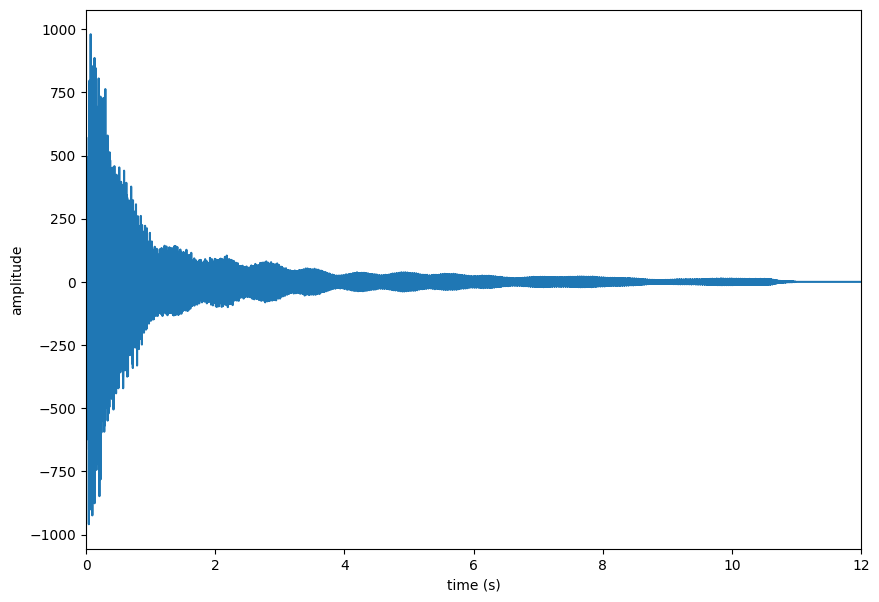

In [8]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [9]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

**3**

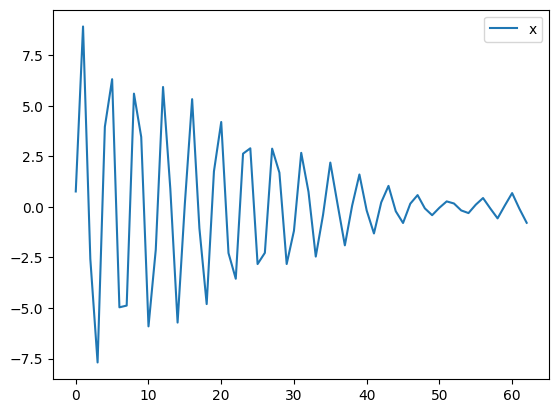

In [10]:
N=63
delta=np.array([-0.05,0])
f=np.array([1/4+1/N,1/4])
a=np.array([10,1])
phi=np.random.uniform(0,2*np.pi,2)
x = Synthesis(N,delta,f,a,phi,RSB=False)
plt.plot(np.real(x), label='x')
plt.legend()
plt.show()

**3.1**

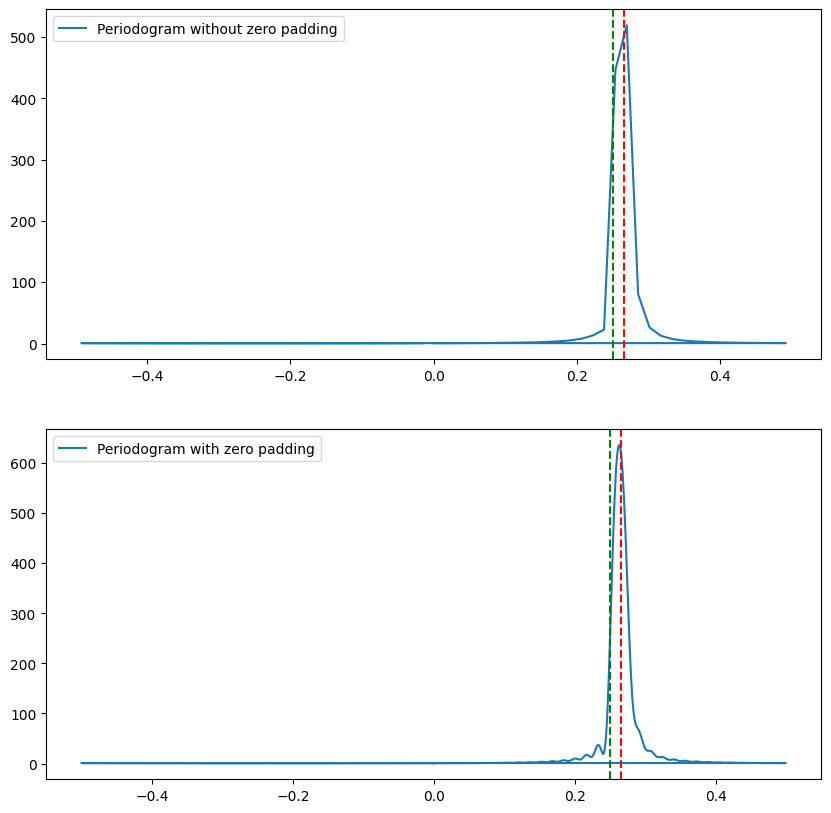

In [11]:
#with zero padding
periodogram=(np.abs(np.fft.fft(x, N)))**2 / N
freq=np.fft.fftfreq(N, d=1)

#without zero padding
periodogram_=(np.abs(np.fft.fft(x,1024)))**2 / N
freq_=np.fft.fftfreq(1024, d=1)

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(freq, periodogram, label="Periodogram without zero padding")
ax[0].legend()
ax[0].axvline(f[0], color='r', linestyle='--', label='f0')
ax[0].axvline(f[1], color='g', linestyle='--', label='f1')

ax[1].plot(freq_, periodogram_, label="Periodogram with zero padding")
ax[1].legend()
ax[1].axvline(f[0], color='r', linestyle='--', label='f0')
ax[1].axvline(f[1], color='g', linestyle='--', label='f1')
plt.show()

Avec ou sans le zero-padding, on ne peut pas separer les deux frequances car on est dans le cas limite ou :  $\Delta f = \frac{1}{N}$

**3.2**

In [12]:
#1
n=32
K=2
l=N+1-n
Hankel_matrix=hankel(x[:n], x[n-1:])
Rxx=Hankel_matrix.dot(Hankel_matrix.T.conj())/l
#2
[U,S,V]=np.linalg.svd(Rxx)
W=U[:,:K]



**3.2.1**


In [13]:
#3
W_up = W[1:,:]
W_down = W[:-1,:]

p= np.linalg.inv(W_down.T.conj().dot(W_down)).dot(W_down.T.conj().dot(W_up))
z_estim = np.linalg.eig(p)[0]
delta_estim = np.log(np.abs(z_estim))
f_estim = np.angle(z_estim)/(2*np.pi)
print(delta_estim,f_estim)
print(delta,f)

[-0.05  0.  ] [0.26587302 0.25      ]
[-0.05  0.  ] [0.26587302 0.25      ]


L'estimation est parfaite.

In [14]:
def ESPRIT(x, n, K):
    l = len(x) - n + 1
    Hankel_matrix=hankel(x[:n], x[n-1:])
    Rxx=Hankel_matrix.dot(Hankel_matrix.T.conj())/l
    [U,S,V] = np.linalg.svd(Rxx)
    W = U[:,:K]
    W_up = W[1:,:]
    W_down = W[:-1,:]
    p = np.linalg.inv(W_down.T.conj().dot(W_down)).dot(W_down.T.conj().dot(W_up))
    z_estim = np.linalg.eig(p)[0]
    delta_estim = np.log(np.abs(z_estim))
    f_estim = np.angle(z_estim)/(2*np.pi)
    return delta_estim, f_estim
print(ESPRIT(x,32,2))

(array([-0.05,  0.  ]), array([0.26587302, 0.25      ]))


In [15]:
def LeastSquares(x, delta,f):
    N=len(x)
    ln_VN=np.outer(np.arange(N),delta+2*1j*np.pi*f)
    VN=np.exp(ln_VN)
    alpha= (np.linalg.inv(VN.conj().T@VN)@VN.conj().T)@x
    return np.abs(alpha),np.abs(np.angle(alpha))

print(LeastSquares(x,delta_estim,f_estim))
print(a,phi)

(array([10.,  1.]), array([1.57781005, 0.58606354]))
[10  1] [4.70537525 0.58606354]



Cette methode fonctionne bien, elle nous permet de separer les deux frequences et estimer les autres paramètres.

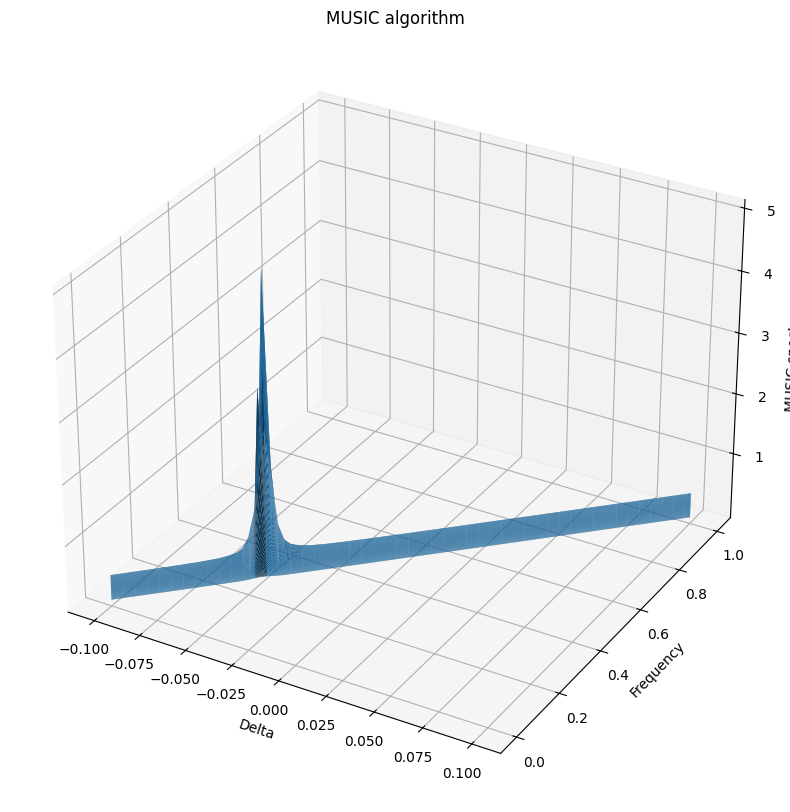

In [16]:
def vn(d,f,n):  
    return np.exp(np.outer(np.arange(n),d+2*1j*np.pi*f))

def MUSIC(x,n,K):
    H=hankel(x[:n],x[n-1:])
    l=N+1-n
    Rxx=H.dot(H.T.conj())/l
    U , s , V = np.linalg.svd(Rxx)
    W=U[:,K:]
    fr=np.linspace(0,1,100)
    delt=np.linspace(-0.1,0.1,100)
    res=np.zeros((len(delt),len(fr)))
    for i in range(len(res)):
        for j in range(len(res[0])):
            res[i][j]=1/np.linalg.norm(W.conj().T@vn(delt[i],fr[j],n))
    
    fig = plt.figure(figsize=(10,10))
    #delt,fr=np.meshgrid(delt,fr)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(delt, fr, res)
    ax.set_xlabel('Delta')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('MUSIC spectrum')
    ax.set_title('MUSIC algorithm')
    plt.show()

MUSIC(x,32,2)


La methode fonctionne aussi, on observe deux pics aux points attendus

**4**

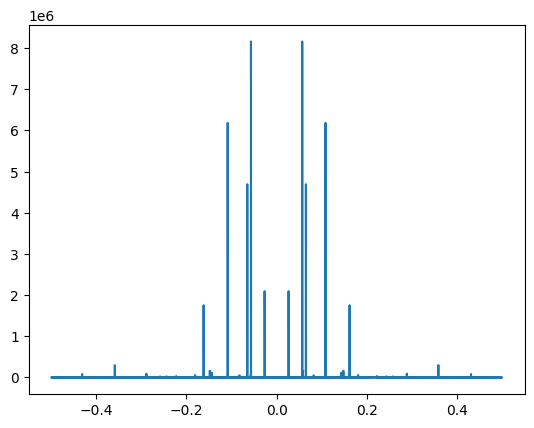

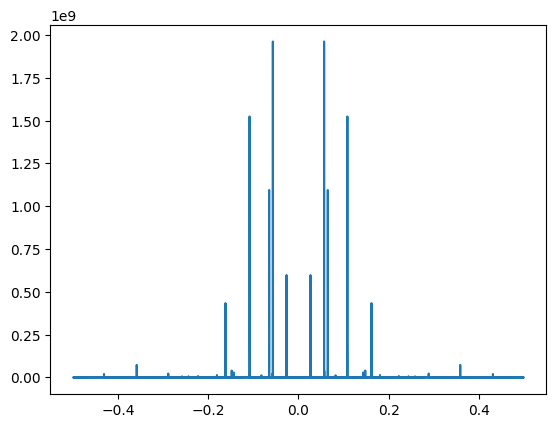

In [17]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())
len_x = x.shape[1]
N=len_x
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
periodogram=(np.abs(np.fft.fft(x[0], N)))**2 / N
freq=np.fft.fftfreq(N, d=1)
plt.plot(freq, periodogram)
plt.show()

T, data, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())
len_x = x.shape[1]
N=len_x
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
periodogram=(np.abs(np.fft.fft(x[0], N)))**2 / N
freq=np.fft.fftfreq(N, d=1)
plt.plot(freq, periodogram)
plt.show()

In [18]:
def ratio_freq(song):
    T, data, nframes, nchannels, sampling_frequency = read_values(song)
    x = np.array(data)
    len_x = x.shape[1]
    x.reshape(len_x)
    perio=(np.abs(np.fft.fft(x[0], N)))**2 / N
    freq=np.fft.fftfreq(N, d=1)
    freq_list=[]
    for _ in range(30):
        n_=np.argmax(perio)
        if freq[n_]>=0:
            freq_list.append(freq[n_])
        for i in range(n_-25,n_+25):
            perio[i]=0
    ratio=sorted(freq_list)
    return ratio/ratio[1]

In [19]:
print(ratio_freq('ClocheA.WAV'))

print(ratio_freq('ClocheB.WAV'))

[0.46778761 1.         1.13929204 1.14389381 1.44814159 1.90442478
 1.90902655 1.91345133 2.52973451 2.60584071 2.84831858 3.18106195
 5.08123894 6.31221239 7.58831858]
[0.46778761 1.         1.13929204 1.14389381 1.90442478 1.90902655
 1.91345133 2.52973451 2.6060177  2.84831858 3.18106195 5.08123894
 6.31221239 7.58831858]


On obtient des rapports proches de la théorie pour les premiers, mais a la fin on a un grand écart.

In [20]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
x=np.array(data)
len_x = x.shape[1]
x=x.reshape(len_x)
K=54
n=512
l=2*n 
N=1535
s=x[5000:5000+N]
d,f=ESPRIT(s,n,K)
a,phi=LeastSquares(s,d,f)

f_plus=f[::2]
f_plus=sorted(f_plus)
print(f_plus/f_plus[1])

[0.46712789 1.         1.00482458 1.14326221 1.44857066 1.90737277
 2.43400241 2.52738704 2.57774101 2.84669164 3.17886957 3.91341845
 4.05953968 4.13186895 4.28190521 4.29113171 4.52012473 4.59973938
 5.07811428 5.48545145 5.63122132 6.28064555 6.30887512 6.6888815
 7.15850156 7.44076207 7.58257653]


Ici aussi les rapports ne correspondent pas a ceux qu'on s'attends, il y a des frequences qui se rajoutent, certainement a cause de l'echo.

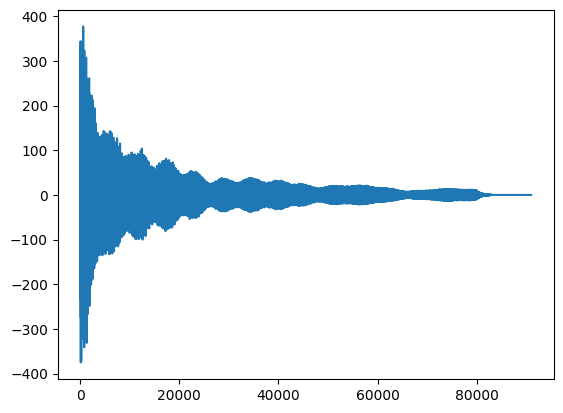

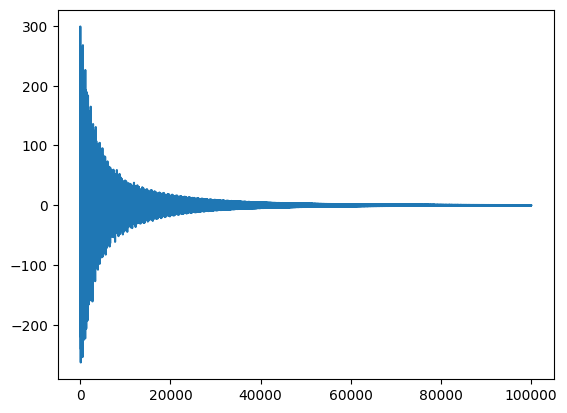

C:\Users\Witt\AppData\Local\Temp\ipykernel_11808\1214070571.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  write('ClocheA_bis.wav', int(sampling_frequency), np.array(regenerate.reshape(100000), dtype=np.int16))


In [21]:
regenerate=Synthesis(100000,d,f,a,phi,RSB=100)
plt.plot(x[5000:])
plt.show()
plt.plot(np.real(regenerate))
plt.show()
Fs = int(wavefile.getframerate())
write('ClocheA_bis.wav', int(sampling_frequency), np.array(regenerate.reshape(100000), dtype=np.int16))

Le son est plutot ressemblant, mais en ayant estimé les paramètres à partir du 5000ieme sample, le son commence plus tard.
L'hypothese faites sur la forme du signal semble cohérente.

In [22]:
IPython.display.Audio('ClocheA_bis.WAV')